In [1]:
# The ultimate target feature: time from one stop to another

# Imports
import pandas as pd
import numpy as np
from datetime import date, datetime
from patsy import dmatrices
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import export_graphviz, DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib 
from statsmodels.formula.api import ols

# Read csv file into a dataframe.
df = pd.read_csv('csv_data/route4.csv')

/Users/user/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1.0 Data Cleaning 

## 1.1 Rename column names

In [2]:
df = df.rename(columns={'Timeframe': 'Start_date'})

## 1.2 Dropping duplicates

In [3]:
df=df.drop_duplicates(keep='first')

## 1.3 Dropping constant columns or columns with missing data

In [4]:
df = df.drop('Direction', axis=1)
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('Congestion', axis=1)
df[df.Journey_Pattern_ID == 'null']
df = df[df['Journey_Pattern_ID'] != '00040002']
df = df[df['Journey_Pattern_ID'] != '00041002']

## 1.4 Remove rows where bus is not at stop

In [5]:
df = df.loc[(df != 0).all(axis=1), :]

# Remove rows that are not last stop on route

In [6]:
df

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,Stop_ID,At_Stop
112,1357029284000000,4.0,00040001,2013-01-01,15475,HN,-6.264970,53.402534,-8,4001,43046,7113,1
117,1357029386000000,4.0,00040001,2013-01-01,15475,HN,-6.263812,53.399124,-36,4001,43046,127,1
127,1357029585000000,4.0,00040001,2013-01-01,15475,HN,-6.265003,53.385361,-108,4001,43046,37,1
136,1357029765000000,4.0,00040001,2013-01-01,15475,HN,-6.270090,53.368137,-187,4001,43046,185,1
154,1357030125000000,4.0,00040001,2013-01-01,15475,HN,-6.261073,53.352112,-496,4001,43046,4725,1
155,1357030145000000,4.0,00040001,2013-01-01,15475,HN,-6.261073,53.352112,-477,4001,43046,4725,1
160,1357030247000000,4.0,00040001,2013-01-01,15475,HN,-6.258871,53.347191,-514,4001,43046,273,1
165,1357030344000000,4.0,00040001,2013-01-01,15475,HN,-6.259240,53.343899,-530,4001,43046,402,1
183,1357030705000000,4.0,00040001,2013-01-01,15475,HN,-6.234490,53.331436,-579,4001,43046,414,1
185,1357030744000000,4.0,00040001,2013-01-01,15475,HN,-6.233015,53.330238,-598,4001,43046,415,1


## 1.5 Group to normalise time & remove rows where bus idle at stop

In [7]:
# Create empty column which will hold normalised time
df['normal_time'] = 0

In [8]:
# Create empty column which will hold the stop order
df['stop_order'] = 0

In [9]:
grouped_df = df.groupby(['Vehicle_Journey_ID', 'Start_date'])

In [10]:
def normalize_time(df):
    """Normalise the time for each journey"""
    for i in range(df['Timestamp'].size):
        df['normal_time'].values[i] = (df['Timestamp'].values[i] - df['Timestamp'].values[0]) / 1000000
        
    return df

In [11]:
norm_gb = grouped_df.apply(normalize_time)

In [12]:
grouped_df = norm_gb.groupby(['Vehicle_Journey_ID', 'Start_date'])

In [13]:
def remove_idle_at_stop(df):
    df = df.drop_duplicates(subset='Stop_ID', keep='first')
    
    return df

In [14]:
norm_gb = grouped_df.apply(remove_idle_at_stop)

In [15]:
grouped_df = norm_gb.groupby(['Vehicle_Journey_ID', 'Start_date'])

/Users/user/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 'Vehicle_Journey_ID' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':
/Users/user/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 'Start_date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


In [16]:
def route_order(df):
    for i in range(df['Timestamp'].size):
        df['stop_order'].values[i] = i+1
    
    return df

In [17]:
df = grouped_df.apply(route_order)

In [18]:
#grouped_df = df.groupby(['Vehicle_Journey_ID', 'Start_date'])

In [19]:
#grouped_df.get_group((4601, '2013-01-29'))

## 1.6 Add new features

In [20]:
df["Time"] = pd.to_datetime(df['Timestamp']*1000, unit="ns")

In [21]:
df['IsWeekend'] = np.where((df['Time'].dt.dayofweek > 5), 1, 0)

In [22]:
df['HourOfDay'] = df['Time'].dt.hour

In [23]:
df['MinsOfHour'] = df['Time'].dt.minute

In [24]:
df['DayOfWeek'] = df['Time'].dt.dayofweek

In [25]:
df['IsEveningTime'] = np.where((df['Time'].dt.hour > 17), 1, 0)

In [26]:
df['IsPeakTime'] = np.where(((df['HourOfDay'] >= 7) & (df['HourOfDay'] <= 10)) | ((df['HourOfDay'] >= 16) & (df['HourOfDay'] <= 19)), 1, 0)

In [27]:
df['RDS_Event'] = np.where((df['Time'].dt.date == datetime(2013, 1, 27).date()), 1, 0)

In [28]:
df['BankHoliday'] = np.where((df['Time'].dt.date == datetime(2013, 1, 1).date()), 1, 0)

In [29]:
df['SchoolHoliday'] = np.where((df['Time'].dt.date == datetime(2012, 11, 1).date()) | (

df['Time'].dt.date == datetime(2012, 11, 2).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 1).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 2).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 3).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 4).date()), 1, 0)

# 2.0 Merge Datasets

## 2.1 Merge bus stop info

In [30]:
df_bus_stop = pd.read_csv('csv_data/busstopinfo.csv', encoding='latin-1')

In [31]:
df_bus_stop = df_bus_stop.rename(columns={'stopid': 'Stop_ID'})
df_bus_stop = df_bus_stop.rename(columns={'fullname': 'Stop_name'})

In [32]:
df_bus_stop = df_bus_stop[['Stop_ID', 'Stop_name']]

In [33]:
df = pd.merge(df, df_bus_stop, on=['Stop_ID'])

## 2.2 Merge weather data

In [34]:
df_weather = pd.read_csv('csv_data/weather_data.csv', encoding='latin-1')

In [35]:
df_weather = df_weather.rename(columns={'Rainfall (Yes or No)': 'Rain'})
df_weather = df_weather.rename(columns={'Temperature C': 'Temperature'})
df_weather = df_weather.rename(columns={'Relative Humidity (%)': 'Humidity'})
df_weather = df_weather.rename(columns={'Over 1mm Rain?': 'Heavy_rain'})
df_weather = df_weather.rename(columns={'Precipitation (mm)': 'Precipitation'})
df_weather = df_weather.rename(columns={'Date': 'Time'})
df_weather['Time'] = pd.to_datetime(df_weather['Time'])
df_weather.sort_values(['Time'], ascending=[True], inplace=True)
df_weather['HourOfDay'] = df_weather['Time'].dt.hour

In [36]:
df.sort_values(['Time'], ascending=[True], inplace=True)
df_weather.sort_values(['Time'], ascending=[True], inplace=True)
df =  pd.merge_asof(df, df_weather, on='Time')

In [37]:
#code from here: https://stackoverflow.com/questions/27313647/merging-two-pandas-dataframes-results-in-duplicate-columns

def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

drop_y(df)
df.columns

Index(['Timestamp', 'LineID', 'Journey_Pattern_ID', 'Start_date',
       'Vehicle_Journey_ID', 'Operator', 'Lon', 'Lat', 'Delay', 'Block_ID',
       'Vehicle_ID', 'Stop_ID', 'At_Stop', 'normal_time', 'stop_order', 'Time',
       'IsWeekend', 'HourOfDay_x', 'MinsOfHour', 'DayOfWeek', 'IsEveningTime',
       'IsPeakTime', 'RDS_Event', 'BankHoliday', 'SchoolHoliday', 'Stop_name',
       'Precipitation', 'Temperature', 'Vapour Pressure (hPa)                ',
       'Humidity', 'Mean Sea Level Pressure (hPa)', 'Rain', 'Heavy_rain'],
      dtype='object')

In [38]:
def rename_x(df):
    for col in df:
        if col.endswith('_x'):
            df.rename(columns={col:col.rstrip('_x')}, inplace=True)
rename_x(df)

In [39]:
df['Proper_rain'] = np.where(((df['Precipitation'] < 2.3) & (df['Precipitation'] > 1.7) & (df['IsPeakTime']==1)), 1, 0)

# 3.0 Remove and categories columns

## 3.1 Drop missing values

In [40]:
df = df[df['Journey_Pattern_ID'] != 'null']

## 3.2 Categorise to continuous and categorical

In [41]:
df['IsWeekend'] = df['IsWeekend'].astype('category')
df['HourOfDay'] = df['HourOfDay'].astype('category')
df['IsEveningTime'] = df['IsEveningTime'].astype('category')
df['SchoolHoliday'] = df['SchoolHoliday'].astype('category')
df['IsPeakTime'] = df['IsPeakTime'].astype('category')
df['Operator'] = df['Operator'].astype('category')
df['At_Stop'] = df['At_Stop'].astype('category')
categorical_columns = df.select_dtypes(['category']).columns

In [42]:
continuous_columns = df.select_dtypes(['int64', 'float64']).columns

## 3.3 Drop columns no longer needed

In [43]:
df = df.drop('Lat', axis=1)
df = df.drop('Lon', axis=1)
df = df.drop('Block_ID', axis=1)
df = df.drop('Operator', axis=1)

## 3.4 Create time to destination feature

In [44]:
df['end_time'] = df.groupby(['Vehicle_Journey_ID', 'Start_date'])['Timestamp'].transform(max)

In [45]:
df['start_time'] = df.groupby(['Vehicle_Journey_ID', 'Start_date'])['Timestamp'].transform(min)

In [46]:
df['time_diff_to_destination'] = df['end_time'] - df['Timestamp']

In [47]:
df = df.loc[(df.Stop_ID == '7113') | (df.Stop_ID == '7330') | (df.Stop_ID == '7226') | (df.Stop_ID == '322')]

In [48]:
df['late'] = ((df['end_time'] - df['start_time']) )
df['time_travelling'] = ((df['Timestamp'] - df['start_time']) )
df['journey_time'] = pd.to_timedelta(df['late']*1000, unit="ns").astype('timedelta64[m]')
df['mins_late'] = ((df['journey_time'].astype(int) - 60))
df['late'] = np.where((df['mins_late'] > 1), 1, 0)
df = df.loc[ (df.Stop_ID == '7226') | (df.Stop_ID == '322')]
df['speed']= ((df['time_travelling'].astype('float64') / df['stop_order'].astype('float64')) )

In [49]:
df.columns

Index(['Timestamp', 'LineID', 'Journey_Pattern_ID', 'Start_date',
       'Vehicle_Journey_ID', 'Delay', 'Vehicle_ID', 'Stop_ID', 'At_Stop',
       'normal_time', 'stop_order', 'Time', 'IsWeekend', 'HourOfDay',
       'MinsOfHour', 'DayOfWeek', 'IsEveningTime', 'IsPeakTime', 'RDS_Event',
       'BankHoliday', 'SchoolHoliday', 'Stop_name', 'Precipitation',
       'Temperature', 'Vapour Pressure (hPa)                ', 'Humidity',
       'Mean Sea Level Pressure (hPa)', 'Rain', 'Heavy_rain', 'Proper_rain',
       'end_time', 'start_time', 'time_diff_to_destination', 'late',
       'time_travelling', 'journey_time', 'mins_late', 'speed'],
      dtype='object')

In [50]:
grouped_df = df.groupby(['Vehicle_Journey_ID', 'Start_date'])

In [51]:
#grouped_df.get_group((4601, '2013-01-29'))

In [52]:
df['Vehicle_Journey_ID'] = pd.to_numeric(df['Vehicle_Journey_ID'], errors='coerce')

#    # Extra plots

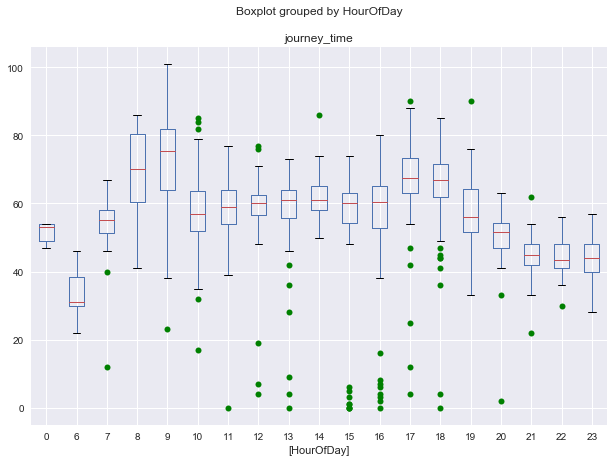

In [53]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['HourOfDay'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Temp_to_late.pdf')

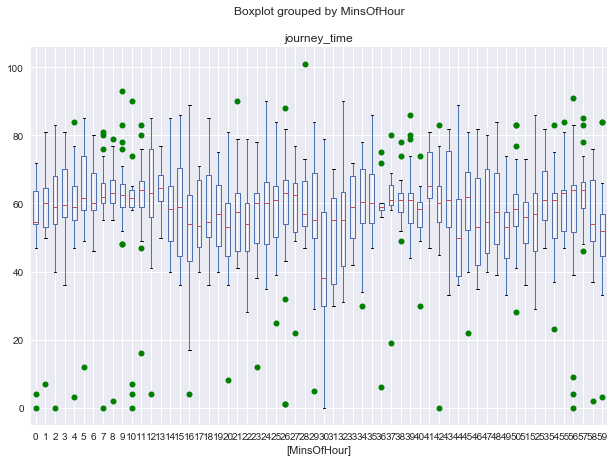

In [54]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['MinsOfHour'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Mins_to_journey_time.pdf')

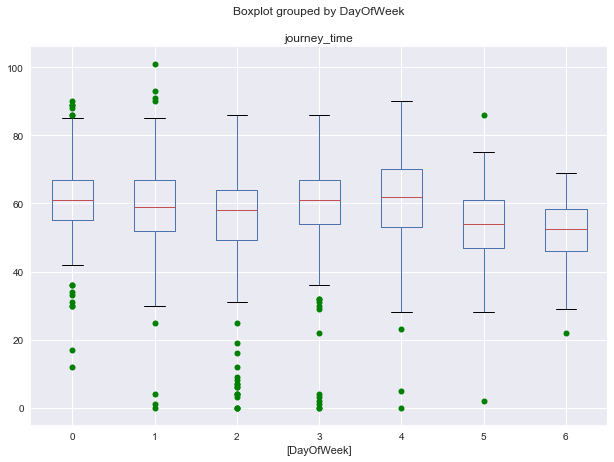

In [55]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['DayOfWeek'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Rain_to_DayOfWeek_chart.pdf')

What is this telling us that there are absolutely no outliers here?

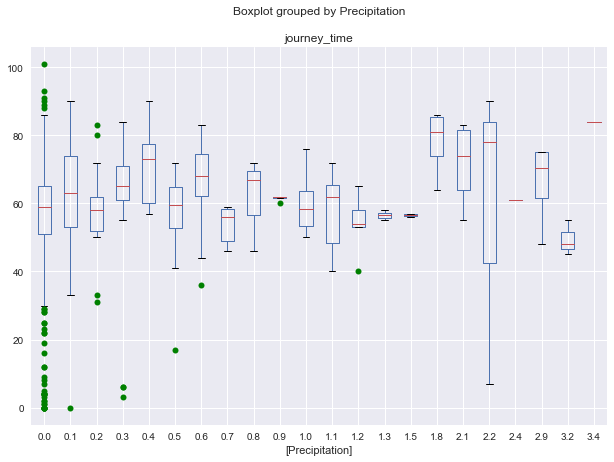

In [56]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['Precipitation'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Rain_to_late.pdf')

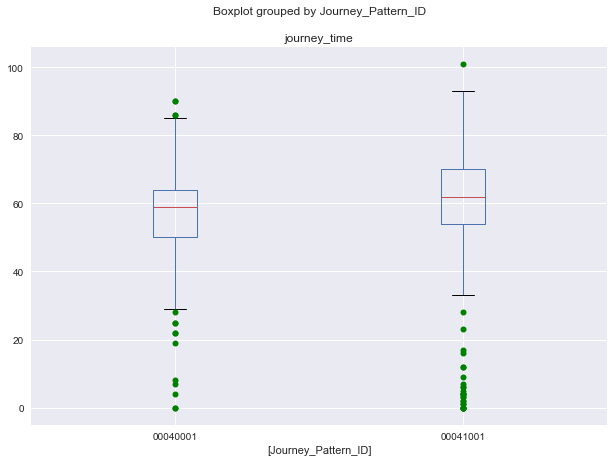

In [57]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['Journey_Pattern_ID'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Journey_Pattern_ID_to_late.pdf')

Represents direction

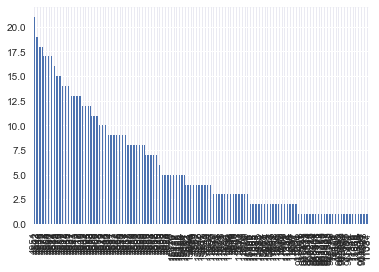

In [58]:
df.Vehicle_Journey_ID.value_counts().plot(kind='bar')

More buses running certain vehicle journey IDs

In [59]:
df.Vehicle_Journey_ID.unique()

array([ 15475,  15486,  15477,  15488,  15664,  15479,  15490,  15666,
        15492,  15668,  15493,  15483,  15494,  15670,   4541,   4571,
         4905,   4542,   4951,   4574,   4585,   4936,   4915,   4906,
         4895,   4543,   4558,   4925,   4573,   4896,   4907,   4953,
         4576,   4587,   4897,   4917,   4908,   4545,   4560,   4927,
         4939,   4909,   4955,   4578,   4589,   4899,   4547,   4562,
         4590,   4929,   4941,   4911,   4957,   4580,   4591, 931773,
         4921,   4549,   4564,   4581,   4931,   4943,   4913,   4550,
         4582,   4959,   4594,   4932,   4593,   4923,   4903,   4551,
         4583,   4934,   4566,   4945,   4904,   4947,   4584,   4553,
         4568,   4949,   4598,   4950,   4555,   4894,   4557,   4572,
         4601,   4586,   4937,   4559,   4938,   4577,   4898,   4919,
       972514, 964017,   4942,   4958,   4592,   4902,   4565,   4944,
         4595,   4935,   4596,   4556,   4952,   4575,   4918,   4910,
      

In [60]:
import statsmodels.formula.api as sm

# Train all continuous features.
check1 = sm.ols(formula="journey_time ~ Proper_rain", data=df).fit()
# Print the weights learned for each feature.
print(check1.summary())

                            OLS Regression Results                            
Dep. Variable:           journey_time   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     23.38
Date:                Thu, 29 Jun 2017   Prob (F-statistic):           1.49e-06
Time:                        00:42:20   Log-Likelihood:                -5178.7
No. Observations:                1271   AIC:                         1.036e+04
Df Residuals:                    1269   BIC:                         1.037e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      58.0294      0.402    144.499      

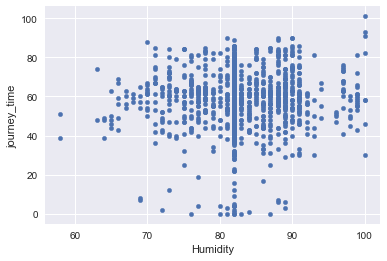

In [61]:
df.plot(kind = 'scatter', y='journey_time', x='Humidity')

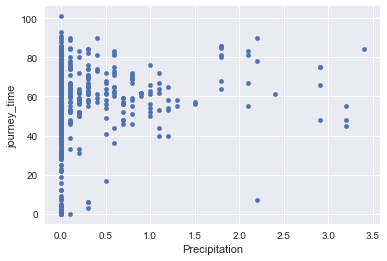

In [62]:
df.plot(kind = 'scatter', y='journey_time', x='Precipitation')

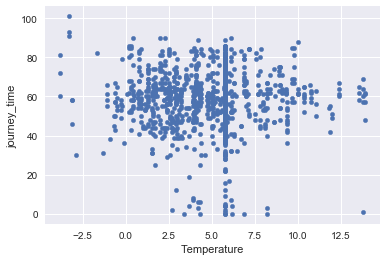

In [63]:
df.plot(kind = 'scatter', y='journey_time', x='Temperature')

In [64]:
df_check_journey_ID = df.loc[df['mins_late'] > 1]
df_check_journey_ID = df_check_journey_ID[['late','Vehicle_Journey_ID']]
df_check_journey_ID.Vehicle_Journey_ID.unique()

array([ 4585,  4906,  4895,  4543,  4925,  4917,  4545,  4909,  4955,
        4589,  4899,  4929,  4591,  4549,  4581,  4931,  4943,  4913,
        4550,  4959,  4932,  4593,  4903,  4936,  4558,  4586,  4937,
        4587,  4938,  4577,  4898,  4939,  4578,  4919,  4547,  4958,
        4592,  4564,  4902,  4565,  4594,  4944,  4915,  4952,  4907,
        4576,  4918,  4579,  4580,  4912,  4582,  4914, 11080, 11349,
       11093, 11339, 11083, 15664, 15489, 15490,  4951,  4575,  4601,
        4897,  4927,  4928,  4940,  4942,  4901,  4923,  4916,  4573,
        4590,  4933,  4922,  4572,  4953,  4559,  4910,  4562,  4957,
        4921,  4930, 11351, 11071, 11357, 11095, 15663, 15488,  4926,
        4920,  4900,  4563,  4905,  4542,  4560,  4546,  4561,  4941,
       11070, 11094, 15481,  4574,  4911,  4956,  4595,  4584,  4588,
       11337, 11354, 11092, 11350, 15665, 15667,  4960])

If Vehicle Journey ID starts with 9 it is never late

In [65]:
df_check_2 = df.loc[(df.Vehicle_Journey_ID == 4585) & (df.Stop_ID == '7226')]
df_check_2.Time

770     2013-01-02 08:22:59
3527    2013-01-03 08:21:18
6329    2013-01-04 08:29:35
11102   2013-01-07 08:41:04
16711   2013-01-09 08:41:08
19527   2013-01-10 08:30:42
22606   2013-01-11 08:41:11
27535   2013-01-14 08:41:52
30618   2013-01-15 08:39:06
33649   2013-01-16 08:33:14
36589   2013-01-17 08:33:44
39548   2013-01-18 08:35:24
44053   2013-01-21 08:41:30
46994   2013-01-22 08:32:19
49985   2013-01-23 08:42:54
55514   2013-01-25 08:43:38
59902   2013-01-28 08:38:46
62590   2013-01-29 08:43:20
Name: Time, dtype: datetime64[ns]

(0, 100)

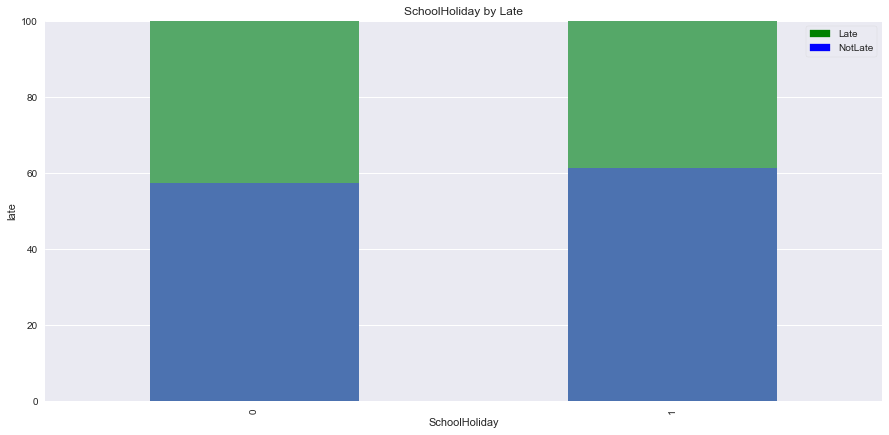

In [66]:
SchoolHoliday = pd.unique(df.SchoolHoliday.ravel())

# Insert a new column called 'percent' and fill it with 0s
df['percent'] = 0

for p in SchoolHoliday:
    count = 1 / df[df.SchoolHoliday == p].count()['late']
    index_list = df[df['SchoolHoliday'] == p].index.tolist()
    for i in index_list:
        df.loc[i, 'percent'] = count * 100
        
# Group dataframe and sum percent
group = df[['percent','SchoolHoliday','late']].groupby(['SchoolHoliday','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="SchoolHoliday by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("SchoolHoliday")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

(0, 100)

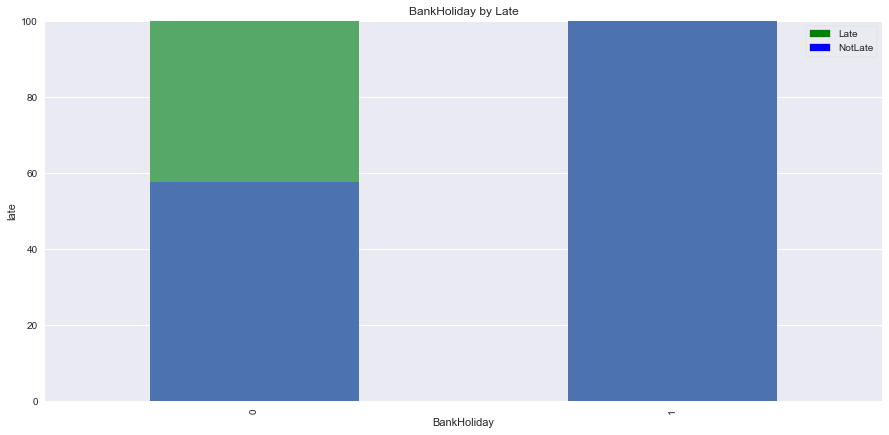

In [67]:
BankHoliday = pd.unique(df.BankHoliday.ravel())

# Insert a new column called 'percent' and fill it with 0s
df['percent'] = 0

for p in BankHoliday:
    count = 1 / df[df.BankHoliday == p].count()['late']
    index_list = df[df['BankHoliday'] == p].index.tolist()
    for i in index_list:
        df.loc[i, 'percent'] = count * 100
        
# Group dataframe and sum percent
group = df[['percent','BankHoliday','late']].groupby(['BankHoliday','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="BankHoliday by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("BankHoliday")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

(0, 100)

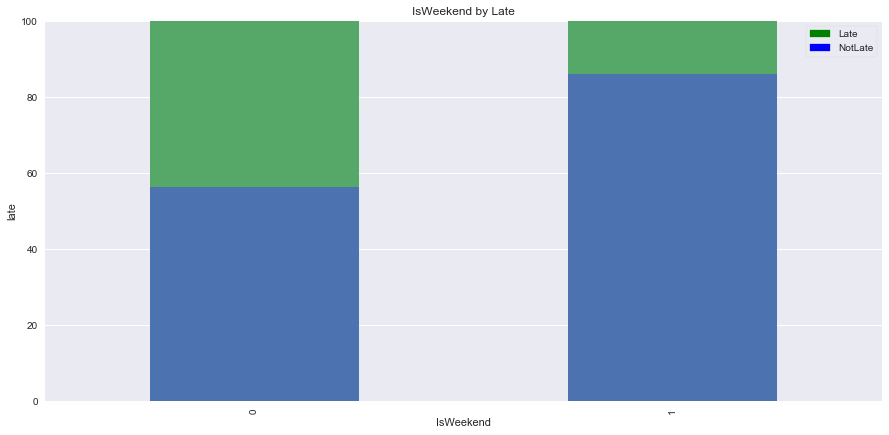

In [68]:
IsWeekend = pd.unique(df.IsWeekend.ravel())

# Insert a new column called 'percent' and fill it with 0s
df['percent'] = 0

for p in SchoolHoliday:
    count = 1 / df[df.IsWeekend == p].count()['late']
    index_list = df[df['IsWeekend'] == p].index.tolist()
    for i in index_list:
        df.loc[i, 'percent'] = count * 100
        
# Group dataframe and sum percent
group = df[['percent','IsWeekend','late']].groupby(['IsWeekend','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="IsWeekend by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("IsWeekend")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

(0, 100)

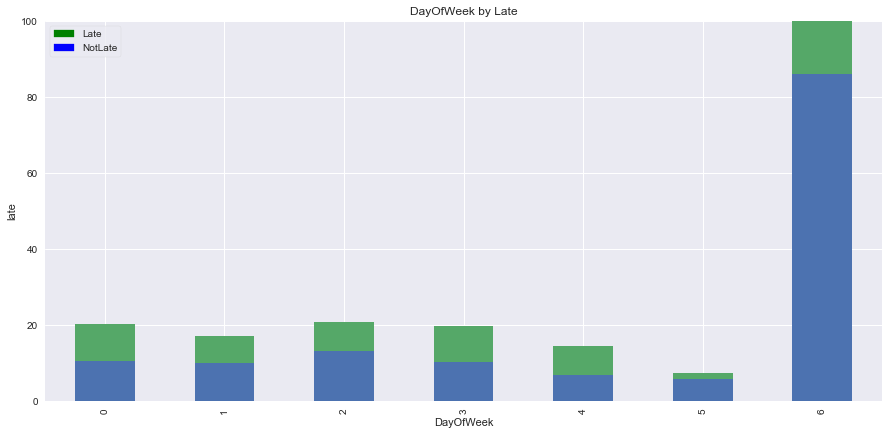

In [69]:
# Group dataframe and sum percent
group = df[['percent','DayOfWeek','late']].groupby(['DayOfWeek','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="DayOfWeek by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("DayOfWeek")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

(0, 100)

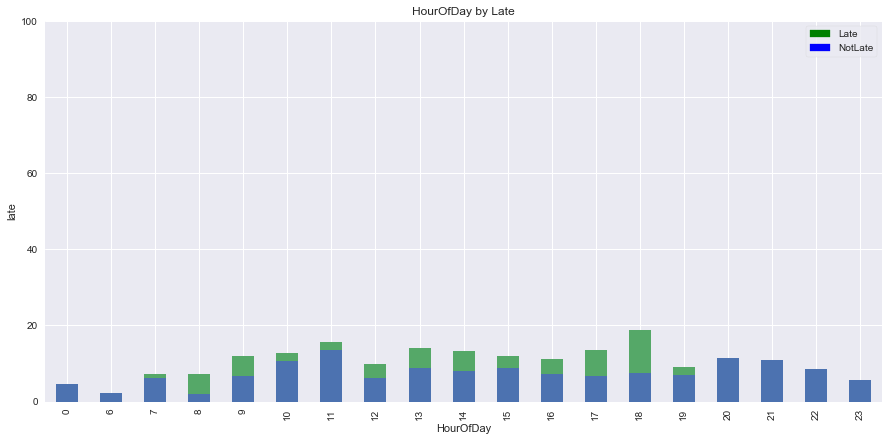

In [70]:
# Group dataframe and sum percent
group = df[['percent','HourOfDay','late']].groupby(['HourOfDay','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="HourOfDay by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("HourOfDay")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

In [71]:
bins=[10,20,30,40,50,60,70,80,90,100,110]

In [72]:
df['time_bins'] = np.digitize(df.journey_time.values, bins=bins)

In [73]:
df

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Delay,Vehicle_ID,Stop_ID,At_Stop,normal_time,...,end_time,start_time,time_diff_to_destination,late,time_travelling,journey_time,mins_late,speed,percent,time_bins
11,1357031839000000,4.0,00040001,2013-01-01,15475,-641,43046,7226,1,2555,...,1357031839000000,1357029284000000,0,0,2555000000,42.0,-18,1.965385e+08,0.083403,4
32,1357035881000000,4.0,00040001,2013-01-01,15486,-200,43040,7226,1,2157,...,1357035881000000,1357033724000000,0,0,2157000000,35.0,-25,2.157000e+08,0.083403,3
75,1357041353000000,4.0,00040001,2013-01-01,15477,-908,43046,7226,1,2928,...,1357041353000000,1357038425000000,0,0,2928000000,48.0,-12,1.126154e+08,0.083403,4
125,1357045376000000,4.0,00040001,2013-01-01,15488,-485,43040,7226,1,3372,...,1357045376000000,1357042004000000,0,0,3372000000,56.0,-4,1.405000e+08,0.083403,5
169,1357048737000000,4.0,00040001,2013-01-01,15664,-724,43047,7226,1,3172,...,1357048737000000,1357045565000000,0,0,3172000000,52.0,-8,1.174815e+08,0.083403,5
212,1357052758000000,4.0,00040001,2013-01-01,15479,-301,43046,7226,1,2986,...,1357052758000000,1357049772000000,0,0,2986000000,49.0,-11,1.357273e+08,0.083403,4
247,1357056120000000,4.0,00040001,2013-01-01,15490,-540,43040,7226,1,3175,...,1357056120000000,1357052945000000,0,0,3175000000,52.0,-8,1.763889e+08,0.083403,5
282,1357059542000000,4.0,00040001,2013-01-01,15666,-658,43036,7226,1,3175,...,1357059542000000,1357056367000000,0,0,3175000000,52.0,-8,1.671053e+08,0.083403,5
346,1357066928000000,4.0,00040001,2013-01-01,15492,-473,43040,7226,1,3364,...,1357066928000000,1357063564000000,0,0,3364000000,56.0,-4,1.682000e+08,0.083403,5
380,1357070170000000,4.0,00040001,2013-01-01,15668,-352,43036,7226,1,2784,...,1357070170000000,1357067386000000,0,0,2784000000,46.0,-14,1.465263e+08,0.083403,4


# 4.0 Save DF to be used in Model Analysis

In [74]:
# Save cleaned dataframe to new CSV file
df.to_csv('csv_data/bus_route4_clean.csv', index=False)

---

In [75]:
df_train = df[:130000]

In [76]:
df_test = df[130000:]

df_group = df.groupby(['Vehicle_Journey_ID', 'Start_date'])